In [22]:
import os
import cv2
import numpy as np
import matplotlib.cm as cm
import tensorflow as tf
import random
import PIL
from PIL import Image, ImageOps
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import splitfolders
%matplotlib inline

In [23]:
os.listdir(f'rooms_dataset/train')  # Directory where training data folders are

['baño', 'exterior', 'zonas_comunes', 'zona_comercial', 'cocina', 'habitación']

In [43]:
num_classes = len(os.listdir(f'rooms_dataset/train'))
dataset_dir ="rooms_dataset"
target_size = (224, 244) #vgg16, resnet152, mobilenet
#target_size = (299, 299) #inceptionv3
batch_size = 32  # Training batch size
print(num_classes)

6


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# preprocessing image and divide validaiton set
train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   brightness_range=[0.5,1.5], 
                                   zoom_range=[0.3,1], 
                                   rotation_range=5)

train_generator = train_datagen.flow_from_directory(dataset_dir+'/train',
                                                 target_size=target_size,
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training')

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(dataset_dir+'/val',
                                                            target_size=target_size,
                                                            batch_size=batch_size,
                                                            class_mode='categorical')


Found 815 images belonging to 6 classes.
Found 206 images belonging to 6 classes.


In [45]:
classes = train_generator.class_indices
print(classes)

{'baño': 0, 'cocina': 1, 'exterior': 2, 'habitación': 3, 'zona_comercial': 4, 'zonas_comunes': 5}


In [46]:
class_names = list(classes.keys())

In [47]:
import math
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

early_stop = EarlyStopping(monitor='val_loss',
                           patience=30,
                           restore_best_weights=True,
                           mode='min')

checkpoint = ModelCheckpoint('logs/ep{epoch:03}-val_loss{val_loss:.3f}.h5', monitor='val_loss',save_best_only=True, verbose=1)

### VGG16

In [48]:
vgg16_model = vgg16.VGG16(weights = 'imagenet' , include_top=False, input_shape = (224, 224, 3))
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [49]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in vgg16_model.layers:
    layer.trainable = False

#if fine_tune es decir cuantas capas quieres reentrenar
# for layer in base_model.layers[:-fine_tune]:
# layer.traineble = False

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [50]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# save the output of the last layer to be the input of the next layer
last_layer = vgg16_model.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten(name="flatten")(last_layer)
#x = Dense(50, activation='relu')(x)
#x = Dense(30, activation='relu')(x)
x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_vgg16_model = Model(inputs=vgg16_model.input, outputs=x)

# print the new_model summary
new_vgg16_model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [51]:
new_vgg16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history_vgg16 = new_vgg16_model.fit(train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=100, verbose=2, callbacks=[checkpoint, early_stop])

Epoch 1/100

Epoch 1: val_loss improved from inf to 5.71866, saving model to logs/ep001-val_loss5.719.h5
26/26 - 200s - loss: 7.0722 - accuracy: 0.6160 - val_loss: 5.7187 - val_accuracy: 0.7718 - 200s/epoch - 8s/step
Epoch 2/100

Epoch 2: val_loss improved from 5.71866 to 3.92393, saving model to logs/ep002-val_loss3.924.h5
26/26 - 184s - loss: 4.0609 - accuracy: 0.7939 - val_loss: 3.9239 - val_accuracy: 0.8155 - 184s/epoch - 7s/step
Epoch 3/100

Epoch 3: val_loss did not improve from 3.92393
26/26 - 177s - loss: 2.6715 - accuracy: 0.8429 - val_loss: 4.0404 - val_accuracy: 0.8350 - 177s/epoch - 7s/step
Epoch 4/100

Epoch 4: val_loss did not improve from 3.92393
26/26 - 199s - loss: 2.1347 - accuracy: 0.8675 - val_loss: 6.9158 - val_accuracy: 0.7961 - 199s/epoch - 8s/step
Epoch 5/100

Epoch 5: val_loss did not improve from 3.92393
26/26 - 190s - loss: 2.5164 - accuracy: 0.8724 - val_loss: 4.3144 - val_accuracy: 0.8447 - 190s/epoch - 7s/step
Epoch 6/100

Epoch 6: val_loss did not improve

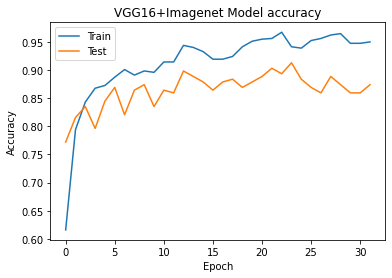

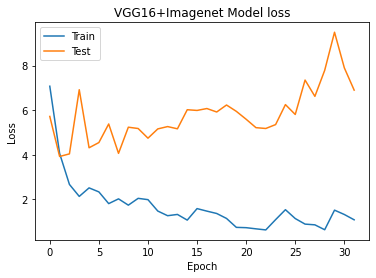

In [54]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('VGG16+Imagenet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('VGG16+Imagenet Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
x, y = zip(*(validation_generator[i] for i in range(len(validation_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = new_vgg16_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

7/7 [==============================] - 36s 5s/step - loss: 3.9239 - accuracy: 0.8155
Accuracy:  0.8155339956283569
Loss:  3.923933506011963


### VGG16 + Places365

In [56]:
#Get the places356 weights
weights_file = 'vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = tf.keras.utils.get_file(weights_file, 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [58]:
vgg16_places_model = vgg16.VGG16(weights = weights_path , include_top=False, input_shape = (224, 224, 3))
vgg16_places_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [59]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in vgg16_places_model.layers:
    layer.trainable = False

#if fine_tune es decir cuantas capas quieres reentrenar
# for layer in base_model.layers[:-fine_tune]:
# layer.traineble = False

vgg16_places_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [60]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# save the output of the last layer to be the input of the next layer
last_layer = vgg16_places_model.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten(name="flatten")(last_layer)
#x = Dense(50, activation='relu')(x)
#x = Dense(30, activation='relu')(x)
x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_vgg16_places_model = Model(inputs=vgg16_places_model.input, outputs=x)

# print the new_model summary
new_vgg16_places_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
new_vgg16_places_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_vgg16_places = new_vgg16_places_model.fit(train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=100, verbose=2, callbacks=[checkpoint, early_stop])

In [ ]:
plt.plot(history_vgg16_places.history['accuracy'])
plt.plot(history_vgg16_places.history['val_accuracy'])
plt.title('VGG16+Places Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history_vgg16_places.history['loss'])
plt.plot(history_vgg16_places.history['val_loss'])
plt.title('VGG16+Places Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
x, y = zip(*(validation_generator[i] for i in range(len(validation_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = new_vgg16_places_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

### ResNet152

In [8]:
weights_path = 'caffemodels/resnet152_keras.h5'

In [10]:
resnet152_model = ResNet152(weights = weights_path , include_top=True, input_shape = (224, 224, 3))
resnet152_model.summary()

ValueError: Weight count mismatch for layer #0 (named conv1_conv in the current model, conv1 in the save file). Layer expects 2 weight(s). Received 1 saved weight(s)

### InceptionV3

### MobileNet